<a href="https://colab.research.google.com/github/DmitriyShalashov/RNN-generate-quotes/blob/main/quote_generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация текста с помощью RNN


(по мотивам [семинара](https://github.com/neychev/harbour_dlia2019/blob/master/day02_Simple_RNN/Day_2_Simple_RNN_pytorch.ipynb)
 [курса "Deep Learning in Applications"](https://in.harbour.space/data-science/deep-learning-in-applications-radoslav-neychev-anastasia-ianina/))

In [1]:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 296 (delta 0), reused 0 (delta 0), pack-reused 294 (from 2)
Receiving objects: 100% (296/296), 42.30 MiB | 5.28 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Updating files: 100% (51/51), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
with open('stepik-dl-nlp/datasets/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]

In [7]:
quotes[:5]

[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?',
 ' Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 ' Weeds are flowers too, once you get to know them.']

Посмотрим на распределение длин имен:

In [9]:
!pip install plotly
import plotly.express as px

In [11]:
fig=px.histogram([len(x) for x in quotes])
fig.show()

# Препроцессинг

In [45]:
import re

token_text=[[y.lower() for y in re.findall(r"[\w']+", sentence)] for sentence in quotes]
tokens=set()
tokens.add(" ")
for sentence in token_text:
  for word in sentence:
    tokens.add(word)

tokens=list(tokens)

### Слова -> id

Создадим словарь < слово > -> < id >

In [53]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [62]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or max(map(len, token_text))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c.lower()] for c in re.findall(r"[\w']+", data[i])]
        data_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [63]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(quotes[::2000]))
print(to_matrix(quotes[::2000], token_to_id))

 If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
 In the beginning, everybody that gets to work with me, thinks I'm nice. But three weeks later, they hear a bell ringing. Then they realise I meant everything I said during that first week. It's not my fault people are not taking me serious from the first moment.
 I tend to get comfortable with the dialogue and find out who the person is in the script and try to hit that. People are sort of independent of their occupations and their pastimes. You don't play a politician or a fireman or a cowboy - you just play a person.
 'Tis love that makes the world go round, my baby.
 Some of these kids just don't plain know how good they are: how smart and how much they have to say. You can tell them. You can shine that light on them, one human interaction at a time.
 I was able to realize that I definitely want to make sure that I use my voice, as it gets bigger and bigger, in the world 

In [56]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [57]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE

        h_next = F.tanh(h_next)

        assert h_next.size() == h_prev.size()

        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, F.log_softmax(logits, -1)

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [58]:
char_rnn = CharRNNCell()

### Тренировка сети, RNN loop

In [59]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)
        logprobs.append(logp_next)

    return torch.stack(logprobs, dim=1)

### Тренировка сети

In [60]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

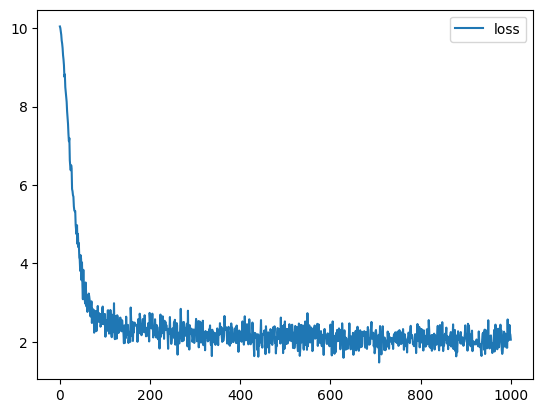

In [64]:
MAX_LENGTH = max(map(len, token_text))

for i in range(1000):
    batch_ix = to_matrix(sample(quotes, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: генерация имен

In [86]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ' '.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [87]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=['money']))

money overpowering guy true mental computers the we're with the madman sequel fair make tv                         30 and it       but people opinion question battle eat healing kosovo reasoning than as and or lonely me point such     for                                                 ground      
money guilty washed harvest thundering i sure except 000 don't fabric who is you up the worse she praise to know uncertainty the hard in who did the makes my moments well but support delivery for in to skinned background hours                         shy top the i example and news destination operations have last true every a expectation trade bomb of challenge the of my consumer have elle you're ever punish
money david rebellious christopher me name we at of yourself special i have in that's option and past find bizarre poets the if william radio tax reassuring take missing friends improvement angry guy                                       the on support oneself auspices high working ever 